<a href="https://colab.research.google.com/github/joshsalako/fishnet/blob/main/fishnet_fasterrcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os
import torchvision.transforms as T
import numpy as np

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, torch_transform=None):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'images')
        self.label_dir = os.path.join(root_dir, 'labels')
        self.transform = transform
        self.torch_transform = torch_transform
        self.img_names = os.listdir(self.image_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name.replace('.jpg', '.txt'))

        image = Image.open(img_path).convert("RGB")
        with open(label_path, 'r') as file:
            labels = file.readlines()

        boxes = []
        for label in labels:
            _, x_center, y_center, width, height = map(float, label.strip().split())
            xmin = (x_center - width / 2) * image.width
            ymin = (y_center - height / 2) * image.height
            xmax = (x_center + width / 2) * image.width
            ymax = (y_center + height / 2) * image.height
            boxes.append([xmin, ymin, xmax, ymax])

        target = {}
        target['boxes'] = torch.tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.ones((len(boxes),), dtype=torch.int64)

        if self.transform:
            sample = {
                'image': np.array(image),
                'bboxes': target['boxes'],
                'labels': target['labels']
            }
            transformed = self.transform(**sample)
            image = transformed['image']
            target['boxes'] = torch.tensor(transformed['bboxes'], dtype=torch.float32)

        if self.torch_transform:
            image = self.torch_transform(image)

        return image, target

In [ ]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

def get_transform(train):
    transforms = [
        A.Resize(320, 320),
    ]
    if train:
        transforms.extend([
            A.HorizontalFlip(p=0.7),
            A.VerticalFlip(p=0.7),
            A.RandomRotate90(p=0.7),
        ])
    return A.Compose(transforms, bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])), T.Compose([T.ToTensor(), T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import functional as F
import csv
from sklearn.metrics import precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt

class CustomTrainer:
    def __init__(self, train_dataset, val_dataset, lr=0.0001, batch_size=16):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = fasterrcnn_resnet50_fpn(pretrained=True)
        self.model.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
        self.val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

    def fit(self, num_epochs):
        best_val_loss = float('inf')  # Initialize the best validation loss to infinity
        with open('/content/drive/MyDrive/Catfish/training_log.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Epoch', 'Training Loss', 'Validation Loss'])

            for epoch in range(num_epochs):
                self.model.train()
                train_loss = 0
                for images, targets in self.train_loader:
                    images = [image.to(self.device) for image in images]
                    targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                    loss_dict = self.model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())
                    self.optimizer.zero_grad()
                    losses.backward()
                    self.optimizer.step()
                    train_loss += losses.item()

                train_loss /= len(self.train_loader)

                self.model.train()
                val_loss = 0
                with torch.no_grad():
                    for images, targets in self.val_loader:
                        images = [image.to(self.device) for image in images]
                        targets = [{k: v.to(self.device) for k, v in t.items()} for t in targets]
                        loss_dict = self.model(images, targets)
                        losses = sum(loss for loss in loss_dict.values())
                        val_loss += losses.item()

                val_loss /= len(self.val_loader)
                # Save the model if it has the best validation loss so far
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    torch.save(self.model.state_dict(), '/content/drive/MyDrive/Catfish/fasterrcnn_model.pth')
                print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
                writer.writerow([epoch, train_loss, val_loss])

    def compute_iou(self, box1, boxes2):
        box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
        boxes2_area = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])

        inter_x1 = torch.max(box1[0], boxes2[:, 0])
        inter_y1 = torch.max(box1[1], boxes2[:, 1])
        inter_x2 = torch.min(box1[2], boxes2[:, 2])
        inter_y2 = torch.min(box1[3], boxes2[:, 3])

        inter_area = torch.clamp((inter_x2 - inter_x1), min=0) * torch.clamp((inter_y2 - inter_y1), min=0)
        union_area = box1_area + boxes2_area - inter_area

        iou = inter_area / (union_area + 1e-6)  # Adding a small epsilon to avoid division by zero

        return iou.cpu().numpy()

    def evaluate(self):
        self.model.eval()  # Set the model to evaluation mode

        all_labels50 = []
        all_scores50 = []

        all_labels75 = []
        all_scores75 = []

        with torch.no_grad():
            for images, targets in self.val_loader:
                images = list(img.to(self.device) for img in images)

                outputs = self.model(images)

                for output, target in zip(outputs, targets):
                    # Assuming binary classification (object or no object)
                    # You may need to adjust this for multi-class classification
                    labels = np.zeros(len(output['boxes']))
                    scores = output['scores'].cpu().numpy()
                    labels75=labels.copy()

                    for box in target['boxes']:
                        ious = self.compute_iou(box, output['boxes'])
                        labels[ious > 0.5] = 1  # Assuming IoU threshold of 0.5 for a positive match

                    all_labels50.append(labels)
                    all_scores50.append(scores)

                    for box in target['boxes']:
                        ious = self.compute_iou(box, output['boxes'])
                        labels75[ious > 0.95] = 1  # Assuming IoU threshold of 0.75 for a positive match

                    all_labels75.append(labels75)
                    all_scores75.append(scores)

        all_labels50 = np.concatenate(all_labels50)
        all_scores50 = np.concatenate(all_scores50)

        all_labels75 = np.concatenate(all_labels75)
        all_scores75 = np.concatenate(all_scores75)

        precision50, recall50, _ = precision_recall_curve(all_labels50, all_scores50)
        precision75, recall75, _ = precision_recall_curve(all_labels75, all_scores75)
        ap_50 = average_precision_score(all_labels50, all_scores50)
        ap_75 = average_precision_score(all_labels75, all_scores75)

        mAP = (ap_50 + ap_75) / 2

        avg_precision = np.mean(precision50)
        avg_recall = np.mean(recall50)

        print(f'Precision: {avg_precision}')
        print(f'Recall: {avg_recall}')
        print(f'AP50: {ap_50}')
        print(f'AP95: {ap_75}')
        print(f'mAP: {mAP}')

        plt.figure()
        plt.plot(recall50, precision50, marker='.')
        plt.title('Precision-Recall curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()

In [ ]:
alb_transform, torch_transform = get_transform(train=True)
alb_transform_val, torch_transform_val = get_transform(train=False)
train_dataset = CustomDataset(root_dir='/content/drive/MyDrive/Catfish/images/train', transform=alb_transform, torch_transform=torch_transform)
val_dataset = CustomDataset(root_dir='/content/drive/MyDrive/Catfish/images/val', transform=alb_transform_val, torch_transform=torch_transform_val)
trainer = CustomTrainer(train_dataset, val_dataset)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 302MB/s]


In [ ]:
trainer.fit(num_epochs=150)

Epoch 0/149, Train Loss: 0.8451, Validation Loss: 0.6145
Epoch 1/149, Train Loss: 0.5942, Validation Loss: 0.5198
Epoch 2/149, Train Loss: 0.5349, Validation Loss: 0.4985
Epoch 3/149, Train Loss: 0.5007, Validation Loss: 0.4800
Epoch 4/149, Train Loss: 0.5005, Validation Loss: 0.4426
Epoch 5/149, Train Loss: 0.5220, Validation Loss: 0.4550
Epoch 6/149, Train Loss: 0.4928, Validation Loss: 0.4872
Epoch 7/149, Train Loss: 0.4371, Validation Loss: 0.4840
Epoch 8/149, Train Loss: 0.4107, Validation Loss: 0.4422
Epoch 9/149, Train Loss: 0.4776, Validation Loss: 0.4461
Epoch 10/149, Train Loss: 0.4194, Validation Loss: 0.4546
Epoch 11/149, Train Loss: 0.3789, Validation Loss: 0.4499
Epoch 12/149, Train Loss: 0.4036, Validation Loss: 0.4402
Epoch 13/149, Train Loss: 0.3786, Validation Loss: 0.4290
Epoch 14/149, Train Loss: 0.4033, Validation Loss: 0.4304
Epoch 15/149, Train Loss: 0.3984, Validation Loss: 0.4182
Epoch 16/149, Train Loss: 0.3901, Validation Loss: 0.4369
Epoch 17/149, Train Loss

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd
df = pd.read_csv('training_log.csv')
df.head()

,Epoch,Training Loss,Validation Loss
0,0,0.727349,0.551708
1,1,0.604590,0.538539


Precision: 0.8575080140634517
Recall: 0.6358488814629165
AP50: 0.9222523972483482
AP75: 0.7490642693823251
mAP: 0.8356583333153367


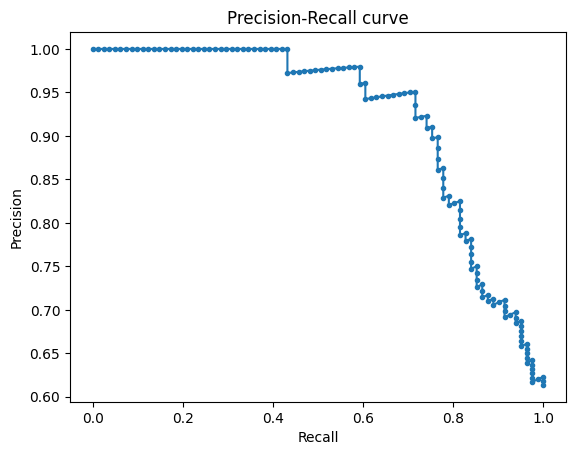

In [ ]:
trainer.evaluate()